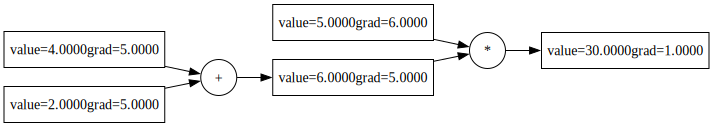

In [ ]:
#I'm going to create a simple graph which will have nodes and edges, be able to do derivatives and thus backpropagation.
#which will be visualized using graphviz.


#things that need to be implemented : 
'''
backward method for backpropagation
layers of neurons 
mlp
loss function 
ways to interate
'''
from graphviz import Digraph


def trace(root): #this is a DFS to get all nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        # value node (box)
        dot.node(uid, label=f"value={n.value:.4f}\ngrad={n.grad:.4f}", shape="record")

        # op node (small circle) if this node was produced by an op
        if n.op:
            op_id = uid + n.op
            dot.node(op_id, label=n.op, shape="circle")
            dot.edge(op_id, uid)  # op -> value

    # connect children -> op node (if present), else children -> value node
    for a, b in edges:
        b_uid = str(id(b))
        if b.op:
            dot.edge(str(id(a)), b_uid + b.op)  # child -> op
        else:
            dot.edge(str(id(a)), b_uid)         # leaf case

    return dot

class Node:
    def __init__(self, value, children=(), op=''):
        self.value = value
        self.grad = 0.0
        self._backward = lambda: None
        self.children = children
        self.op = op

    def __add__(self, other):   
        out = Node(self.value + other.value, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        out = Node(self.value - other.value, (self, other), '-')
        def _backward(): 
            self.grad += out.grad
            other.grad += -1*out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Node(self.value * other.value, (self, other), '*')    
        def _backward(): 
            self.grad += out.grad*other.value
            other.grad += out.grad*self.value
        out._backward = _backward
        return out
    
    def __repr__(self):
        return f"Node(value={self.value}, grad={self.grad}, op='{self.op}')"
    
    def relu(self):
        out = Node(0.0 if self.value < 0 else self.value, (self,), 'ReLU')

        def _backward():
            # d/dx ReLU(x) = 1 if x > 0 else 0
            self.grad += (out.value > 0) * out.grad

        out._backward = _backward
        return out
    
    
    def backward(self):
        visited = set()
        topo = []

        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build(child)
                topo.append(v)

        build(self)

        self.grad = 1.0  # seed here

        for node in reversed(topo):
            node._backward()


n1 = Node(2)
n2 = Node(4)
n3 = n1.__add__(n2)
n4 = Node(5)
n5 = n3.__mul__(n4)
L = n5.relu()

L.backward()
dot = draw_dot(L)
dot









